In [ ]:
import numpy as np
import pandas as pd

class TreeNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class CART:
    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y):
        if len(set(y)) == 1:
            return TreeNode(value=y[0])

        best_gain = -float('inf')
        best_criteria = None
        best_sets = None

        n_samples, n_features = X.shape
        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                gain = self._gini_gain(y, left_indices, right_indices)
                if gain > best_gain:
                    best_gain = gain
                    best_criteria = (feature_index, threshold)
                    best_sets = (left_indices, right_indices)

        if best_gain == -float('inf'):
            return TreeNode(value=np.bincount(y).argmax())

        left_node = self._grow_tree(X[best_sets[0]], y[best_sets[0]])
        right_node = self._grow_tree(X[best_sets[1]], y[best_sets[1]])
        return TreeNode(feature_index=best_criteria[0], threshold=best_criteria[1], left=left_node, right=right_node)

    def _gini_gain(self, y, left_indices, right_indices):
        parent_impurity = self._gini_impurity(y)
        left_impurity = self._gini_impurity(y[left_indices])
        right_impurity = self._gini_impurity(y[right_indices])
        n = len(y)
        n_left = len(y[left_indices])
        n_right = len(y[right_indices])
        weighted_child_impurity = (n_left / n) * left_impurity + (n_right / n) * right_impurity
        return parent_impurity - weighted_child_impurity

    def _gini_impurity(self, y):
        class_counts = np.bincount(y)
        return 1.0 - np.sum((class_counts / len(y)) ** 2)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _predict(self, inputs):
        node = self.root
        while node.value is None:
            if inputs[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value


In [ ]:
from sklearn.tree import DecisionTreeClassifier

def build_id3(X_train, y_train):
    model = DecisionTreeClassifier(criterion='entropy')  # ID3 uses entropy
    model.fit(X_train, y_train)
    return model

def build_c45(X_train, y_train):
    model = DecisionTreeClassifier(criterion='gini')  # C4.5 uses Gini impurity
    model.fit(X_train, y_train)
    return model


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test) if hasattr(model, 'predict') else model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Avoid division by zero

    return accuracy, recall, precision, sensitivity


CART Metrics (Accuracy, Recall, Precision, Sensitivity): (0.6927374301675978, 0.6891891891891891, 0.6144578313253012, 0.6891891891891891)
ID3 Metrics (Accuracy, Recall, Precision, Sensitivity): (0.7262569832402235, 0.6891891891891891, 0.6623376623376623, 0.6891891891891891)
C4.5 Metrics (Accuracy, Recall, Precision, Sensitivity): (0.7262569832402235, 0.6756756756756757, 0.6666666666666666, 0.6756756756756757)


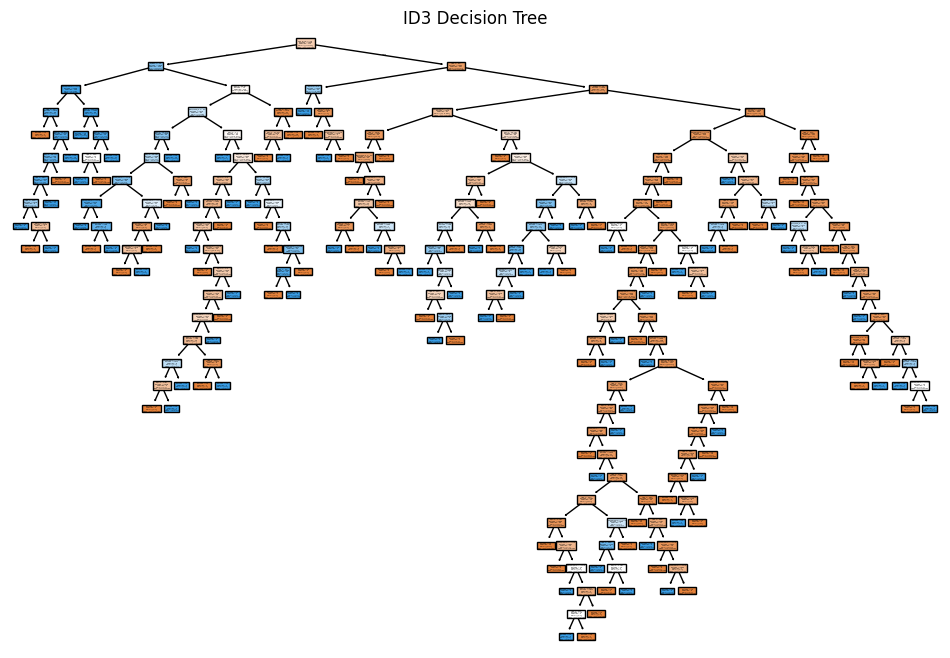

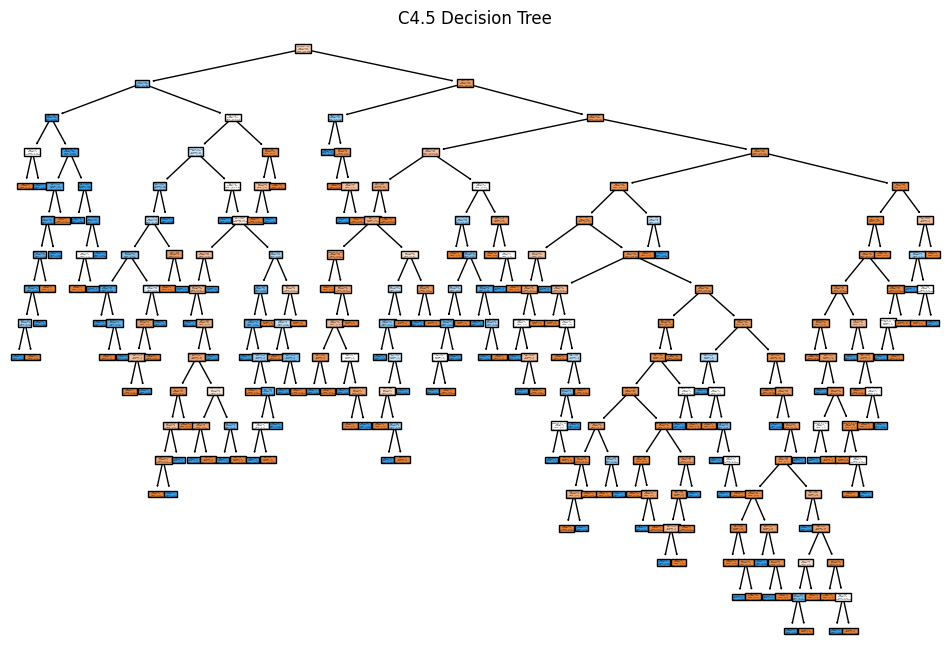

In [ ]:
from sklearn.model_selection import train_test_split

def load_titanic_dataset():
    url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
    data = pd.read_csv(url)

    # Preprocess the data: drop rows with missing target and fill missing values
    data = data.drop(columns=["Name", "Ticket", "Cabin"])  # Drop non-feature columns
    data['Embarked'] = data['Embarked'].fillna('S')  # Fill missing Embarked
    data['Age'] = data['Age'].fillna(data['Age'].median())  # Fill missing Age with median
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())  # Fill missing Fare with median

    # Convert categorical variables to dummy variables
    data = pd.get_dummies(data, columns=["Sex", "Embarked"], drop_first=True)

    X = data.drop("Survived", axis=1)  # Features
    y = data["Survived"]  # Target labels
    return train_test_split(X, y, test_size=0.2, random_state=42)

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def compare_models():
    X_train, X_test, y_train, y_test = load_titanic_dataset()

    # Implement CART from scratch
    cart_model = CART()
    cart_model.fit(X_train.to_numpy(), y_train.to_numpy())

    # Using scikit-learn for ID3 and C4.5
    id3_model = build_id3(X_train, y_train)
    c45_model = build_c45(X_train, y_train)

    # Evaluate models
    cart_metrics = evaluate_model(cart_model, X_test.to_numpy(), y_test.to_numpy())
    id3_metrics = evaluate_model(id3_model, X_test, y_test)
    c45_metrics = evaluate_model(c45_model, X_test, y_test)

    # Print comparison
    print("CART Metrics (Accuracy, Recall, Precision, Sensitivity):", cart_metrics)
    print("ID3 Metrics (Accuracy, Recall, Precision, Sensitivity):", id3_metrics)
    print("C4.5 Metrics (Accuracy, Recall, Precision, Sensitivity):", c45_metrics)

    # Visualize the CART tree
    plt.figure(figsize=(12, 8))
    plot_tree(id3_model, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
    plt.title("ID3 Decision Tree")
    plt.show()

    plt.figure(figsize=(12, 8))
    plot_tree(c45_model, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
    plt.title("C4.5 Decision Tree")
    plt.show()

# Run the comparison
compare_models()
